# S4: celling cell analysis

In [1]:
from notebook_utils import *

# print modules and versions            
imports()

/home/ubuntu/py_36_env/lib/python3.6/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/ubuntu/py_36_env/lib/python3.6/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


pandas: 1.0.3
numpy: 1.18.2
scanpy.api: 1.4.4.post1
anndata: 0.6.22rc1
plotnine: 0.6.0
scipy: 1.4.1
more_itertools: 8.2.0
tqdm: 4.45.0
sklearn: 0.22.2.post1
lifelines: 0.24.3
matplotlib: 3.0.3


In [2]:
# import adata and associated files
wkdir = '/home/ubuntu/data/DL20181011_melanocyte_test_data/local_data'

for file in ['raw_adata', 
             'full_adata',
             'DE_df',
            ]:
    var = pickle.load((open(f'{wkdir}/{file}.p', 'rb')))
    exec(f'{file} = var')
    del var
    
# for parallel processes
usable_cores = multiprocessing.cpu_count()-1

# update subtypes
full_adata.obs['subtypes'] = ['follicular' if x in ['light_foll_mel', 'dark_foll_mel', 'cyc_foll_mel'] \
                         else y \
                         for x,y in zip(full_adata.obs.class_1, full_adata.obs.subtypes)]

# label order
dev_stage_order = ['fet','neo','adt']
subtypes_order = ['cutaneous','acral','foreskin','follicular']
acral_subtype_order = ['acral','not_acral']
foreskin_subtype_order = ['foreskin','not_foreskin']
follicular_subtype_order = ['follicular','not_follicular']
dev_subtype_order = ['fet_acral','fet_cutaneous','fet_follicular','neo_foreskin','adt_acral','adt_cutaneous']

# create class_2 for site granularity
full_adata.obs['class_2'] = [x if x not in ['mel'] \
                             else f'{y}_mel'
                             for x,y in zip(full_adata.obs['class_1'], full_adata.obs['subtypes'])]

# create class_3 for site+dev_stage granularity
full_adata.obs['class_3'] = [x if not x.endswith('_mel') or x.startswith('cyc_') \
                             else f'{y}_{x}'
                             for x,y in zip(full_adata.obs['class_2'], full_adata.obs['dev_stage'])]

# update class_1 to pool by cell type
full_adata.obs['class_1'] = [x if not x.endswith('_mel') \
                             else 'mel' if not x.startswith('cyc_') \
                             else 'cyc_mel' \
                             for x in full_adata.obs['class_1']]
    
DE_df['class_1'] = (DE_df['class_1']
                      .astype(str)
                      .astype(CategoricalDtype(type_order_1, ordered=True))
                     )
DE_df = DE_df.dropna()


In [3]:
sc.pp.neighbors(full_adata, n_pcs=20, n_neighbors=100, random_state=1) # new
sc.tl.umap(full_adata, min_dist = 0.5, random_state=1, init_pos='random')

/home/ubuntu/py_36_env/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../py_36_env/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/ubuntu/py_36_env/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../py_36_env/lib/python3.6/site-packages/umap/utils.py", line 

## cycling sore
ref: https://www.biorxiv.org/content/biorxiv/early/2019/02/03/526848.full.pdf 

high = G2/M, low = G1/S

In [4]:
cycling_module = ['TOP2A','CDK1','UBE2C','CDT1'] # 4 genes positively correlate
input_adata = full_adata

input_adata.obs['cell'] = input_adata.obs.index.tolist()
input_adata.obs['cell'] = (input_adata
                          .obs['cell']
                          .astype(str)
                          .astype(CategoricalDtype(input_adata.obs['cell'].tolist())))
cat, exp_df = prepare_dataframe(input_adata,
                 var_names = input_adata.var_names,
                 groupby = 'cell')
exp_df = exp_df.rank(pct=True, axis=1, method = 'dense') # ranking per cell

input_adata.obs['cycling_score'] = exp_df.loc[:,cycling_module].mean(axis=1)


0.02


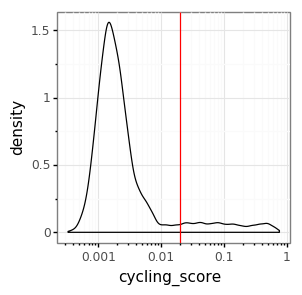

<ggplot: (8779672393939)>

In [5]:
cycling_df = input_adata.obs.loc[:,['cycling_score']]
cutoff = 0.02
print(cutoff)

plotnine.options.figure_size = (3,3)
plot_df = (ggplot(cycling_df)
           + theme_bw()
           + scale_x_log10()
           + geom_density(aes('cycling_score'))
           + geom_vline(aes(xintercept = cutoff), 
            color = 'red')
          )
plot_df

## UMAP with cycling score

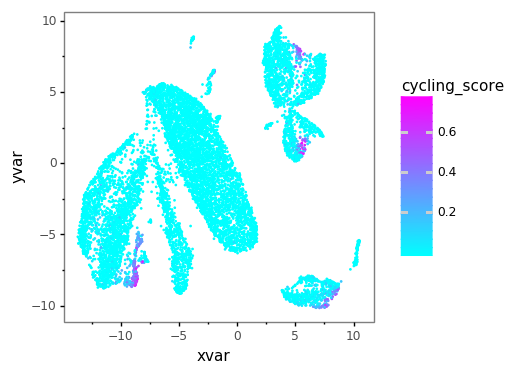

<ggplot: (-9223363257182989694)>


In [6]:
umap_df = pd.DataFrame(input_adata.obsm['X_umap'], columns = ['xvar','yvar'])
umap_df['cycling_score'] = input_adata.obs['cycling_score'].values

plotnine.options.figure_size = (4,4)
plot = (ggplot(umap_df)
        + theme_bw()
        + theme(aspect_ratio = 1,
                panel_grid_major = element_blank(), 
                panel_grid_minor = element_blank()
               )
        + geom_point(aes('xvar','yvar',color='cycling_score'), size = 0.1)
        + scale_color_cmap('cool')
       )
print(plot)

## UMAP with binary cycling label

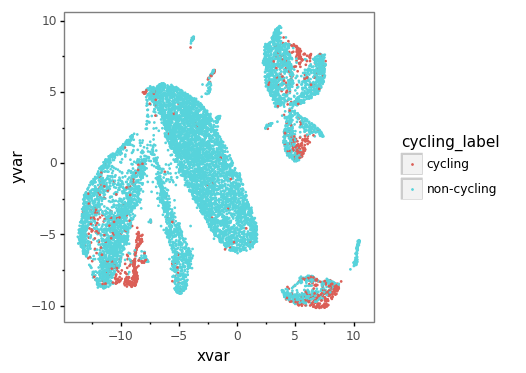

<ggplot: (-9223363257183033803)>


In [7]:
input_adata = full_adata

umap_df = pd.DataFrame(input_adata.obsm['X_umap'], columns = ['xvar','yvar'])
umap_df['cycling_score'] = input_adata.obs['cycling_score'].values
umap_df['cycling_label'] = ['cycling' if x>cutoff else \
                            'non-cycling' for x in umap_df['cycling_score']]

plotnine.options.figure_size = (4,4)
plot = (ggplot(umap_df)
        + theme_bw()
        + theme(aspect_ratio = 1,
                panel_grid_major = element_blank(), 
                panel_grid_minor = element_blank()
               )
        + geom_point(aes('xvar','yvar',color='cycling_label'), size = 0.1)
       )
print(plot)

## Fraction cycling per cell type

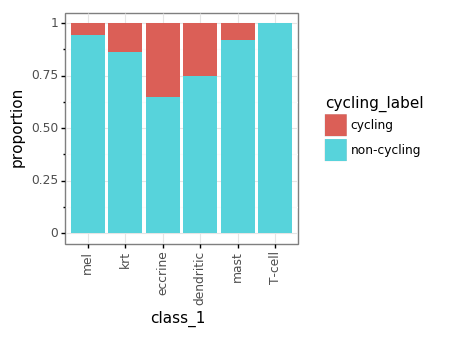

<ggplot: (8779671773914)>

In [8]:
input_adata = full_adata

cell_frac_df = input_adata.obs.loc[:,['class_1','cycling_score']]
cell_frac_df['class_1'] = [x[4:] if x.startswith('cyc_') \
                           else x for x in cell_frac_df['class_1']]
cell_frac_df['cycling_label'] = ['cycling' if x>cutoff else \
                            'non-cycling' for x in cell_frac_df['cycling_score']]
cell_frac_df = ((pd.DataFrame(cell_frac_df.groupby('class_1')['cycling_label'].value_counts())/\
                pd.DataFrame(cell_frac_df.groupby('class_1')['cycling_label'].count())
               ).rename(columns = {'cycling_label':'proportion'})
                .reset_index()
               )
cell_frac_df['class_1'] = (cell_frac_df['class_1']
                           .astype(str)
                           .astype(CategoricalDtype([x for x in type_order_1 \
                                                     if x in set(cell_frac_df['class_1'])
                                                    ], ordered=True))
                          )
cell_frac_df = cell_frac_df.dropna()

plotnine.options.figure_size = (3,3)
plot = (ggplot(cell_frac_df)
        + theme_bw()
        + theme(axis_text_x = element_text(angle=90))
        + geom_bar(aes('class_1','proportion',fill='cycling_label'), stat='identity')
       )
plot

## cycling cell proportion x age

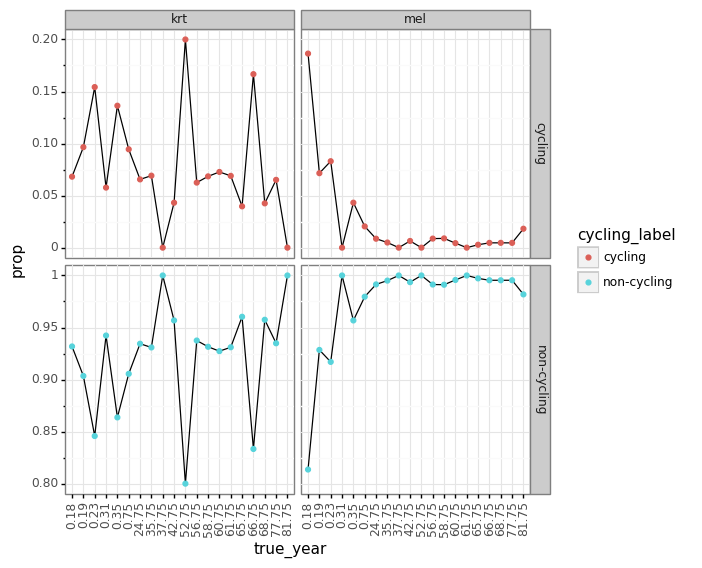

<ggplot: (-9223363284321903507)>

In [9]:
cell_frac_df = (input_adata
                .obs
                .loc[:,['class_1','true_year','cycling_score']]
               )
cell_frac_df['true_year'] = (cell_frac_df['true_year']
                             .round(2)
                             .astype(str)
                            )
ref_df = pd.DataFrame()
for x in set(cell_frac_df['true_year']):
    dfslice = pd.DataFrame({'class_1':['krt','krt','mel','mel'],
                           'cycling_label':['non-cycling','cycling','non-cycling','cycling',]})
    dfslice['true_year'] = x
    ref_df = ref_df.append(dfslice, ignore_index=True)
ref_df

cell_frac_df['cycling_label'] = ['cycling' if x>cutoff else \
                            'non-cycling' for x in cell_frac_df['cycling_score']]
cell_frac_df = cell_frac_df[[x in ['mel','krt'] for x in cell_frac_df['class_1']]]
cv = (pd.DataFrame(cell_frac_df.groupby(['true_year','class_1'])['cycling_label'].value_counts())
      .rename(columns = {'cycling_label':'count'})
      .reset_index()
     )
cv = (pd.merge(cv,ref_df,'right',['class_1','true_year','cycling_label'])
      .replace(np.nan,0)
      .set_index(['class_1','true_year','cycling_label'])
     )
cs = pd.DataFrame(cv.groupby(['true_year','class_1'])['count'].sum())

cell_frac_df = cv/cs
cell_frac_df = (cell_frac_df
                .rename(columns={'count':'prop'})
                .reset_index()
               )

order_list = sorted(list(set(cell_frac_df['true_year'])))
cell_frac_df['true_year'] = (cell_frac_df['true_year']
                             .astype(str)
                             .astype(CategoricalDtype(order_list, ordered = True))
                            )
plotnine.options.figure_size = (6,3)
plot = (ggplot(cell_frac_df)
        + theme_bw()
        + theme(axis_text_x = element_text(angle=90),
                aspect_ratio = 1
               )
        + geom_line(aes('true_year','prop',group='cycling_label'))
        + geom_point(aes('true_year','prop',color='cycling_label'))
        + facet_grid('cycling_label~class_1', scales='free')

       )
plot